# File and libraries

In [242]:
import pandas as pd
import numpy as np


#filepath=r'dataset/df_ecom_2_2_mv_input'
filepath=r'dataset/df_ecom_2_3_outliers_input'

file_tag = "Multicategory Store"

# DSLabs functions

In [158]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [159]:
%run "data_functions.py"


data_functions loaded


# Load

In [243]:
# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(f"{filepath}_test.csv")
    train= pd.read_csv(f"{filepath}_train.csv")

    sample=0.005
    df = df.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    
    # create sample df version of test/train for variance studies
    test_sample= test
    train_sample= train
    
else:
    df=pd.read_csv(f"{filepath}.csv")

    
    test= pd.read_csv(f"{filepath}_test.csv")
    train= pd.read_csv(f"{filepath}_train.csv")

    # create sample for variance studies
    sample=0.2
    test_sample = test.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train_sample = train.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)


 
target='is_purchase'

target_metric_2='precision'
target_metric='f2'
vars: list[str] = df.columns.to_list()


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235411 entries, 0 to 235410
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  235411 non-null  float64
 1   category_code_lvl_2  235411 non-null  float64
 2   price                235411 non-null  float64
 3   is_purchase          235411 non-null  int64  
 4   activity_in_session  235411 non-null  float64
 5   week_of_month        235411 non-null  int64  
 6   is_weekend           235411 non-null  int64  
 7   day                  235411 non-null  int64  
 8   brand_value          235411 non-null  float64
 9   product_category     235411 non-null  int64  
 10  time_of_day_sin      235411 non-null  float64
 11  time_of_day_cos      235411 non-null  float64
 12  day_of_week_sin      235411 non-null  float64
 13  day_of_week_cos      235411 non-null  float64
 14  hour_sin             235411 non-null  float64
 15  hour_cos             2

In [145]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (180833, 18)
Test shape: (77501, 18)


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180833 entries, 0 to 180832
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  180833 non-null  float64
 1   category_code_lvl_2  180833 non-null  float64
 2   price                180833 non-null  float64
 3   activity_in_session  180833 non-null  float64
 4   week_of_month        180833 non-null  float64
 5   is_weekend           180833 non-null  float64
 6   day                  180833 non-null  float64
 7   brand_value          180833 non-null  float64
 8   product_category     180833 non-null  float64
 9   time_of_day_sin      180833 non-null  float64
 10  time_of_day_cos      180833 non-null  float64
 11  day_of_week_sin      180833 non-null  float64
 12  day_of_week_cos      180833 non-null  float64
 13  hour_sin             180833 non-null  float64
 14  hour_cos             180833 non-null  float64
 15  min_sin              1

# Feat 1 - Dropping Low Variance Variables

## Feat 1 - Study Low Variance Variables and Threshold

using sampled dataframe due to heavy processing

In [246]:
max_thresh=0.7
lag_variance=0.04
mandatory_cols=[ 
'day_of_week_sin',
'activity_in_session',
'week_of_month',
'day_of_week_cos',
'hour_sin',
'hour_cos',
'day',
'is_purchase'
]


Testing threshold: 0.04
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.04: {'accuracy': [0.5997592749929198, 0.7778249787595582], 'recall': [0.3641915782706525, 0.010286081645773062], 'precision': [0.23564891846921798, 0.3516483516483517], 'auc': [0.5152475189092298, 0.5024643883212975], 'f1': [0.286147240813234, 0.019987507807620236], 'f2': [0.32836772548110366, 0.012764260071798962]}
Evaluation for precision: [0.23564891846921798, 0.3516483516483517]
Testing threshold: 0.08
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.08: {'accuracy': [0.5997592749929198, 0.7778249787595582], 'recall': [0.3641915782706525, 0.010286081645773062], 'precision': [0.23564891846921798, 0.3516483516483517], 'auc': [0.5152475189092298, 0.5024643883212975], 'f1': [0.286147240813234, 0.019987507807620236], 'f2': [0.32836772548110366, 0.012764260071798962]}
Evaluation for precision: [0.23564891846921798, 0.3516483516483517

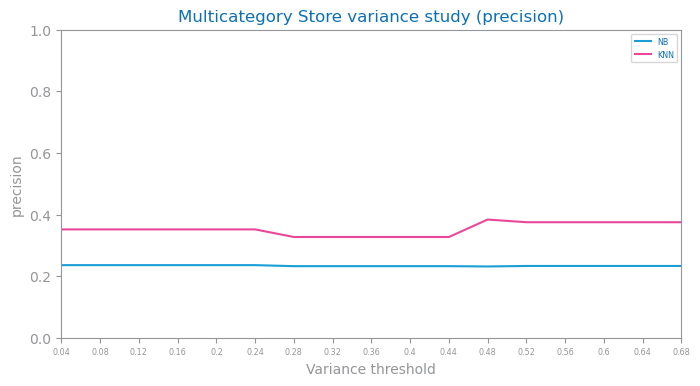

In [247]:

# Usage example
if evaluate == True:
    eval_metric = target_metric_2
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_variance_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        max_threshold=max_thresh,
        lag=lag_variance,
        metric=eval_metric,
        file_tag=file_tag,
        min_features_to_keep=10,  # Minimum features safeguard
        exclude=mandatory_cols  # Exclude mandatory columns
    )
    show()



### target_metric_2 - precision

Testing threshold: 0.025
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.025: {'accuracy': [0.5861557318882653, 0.7770466421521193], 'recall': [0.3699912255045335, 0.016379058204153262], 'precision': [0.22891784292435757, 0.37583892617449666], 'auc': [0.5086589135302836, 0.5043408285558094], 'f1': [0.28283957518166575, 0.03139013452914798], 'f2': [0.3293927715862931, 0.020253164556962026]}
Evaluation for precision: [0.22891784292435757, 0.37583892617449666]
Testing threshold: 0.05
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.05: {'accuracy': [0.5861557318882653, 0.7770466421521193], 'recall': [0.3699912255045335, 0.016379058204153262], 'precision': [0.22891784292435757, 0.37583892617449666], 'auc': [0.5086589135302836, 0.5043408285558094], 'f1': [0.28283957518166575, 0.03139013452914798], 'f2': [0.3293927715862931, 0.020253164556962026]}
Evaluation for precision: [0.22891784292435757, 0.37583892617

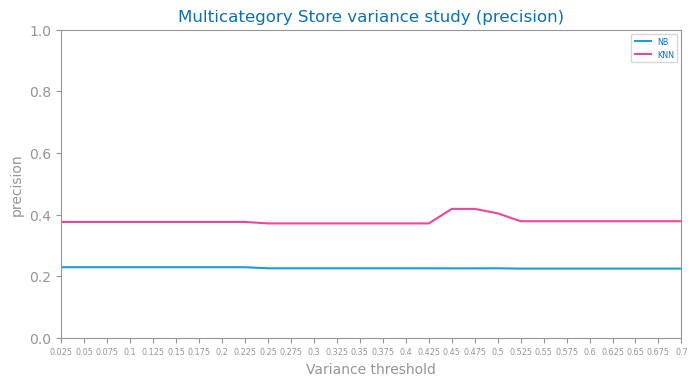

In [127]:
# modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)
if evaluate==True:

    eval_metric = target_metric_2
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_variance_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        max_threshold=max_thresh,
        lag=lag_variance,
        metric=eval_metric,
        file_tag=file_tag,
        min_features_to_keep = 10,  # Minimum features safeguard
        exclude=mandatory_cols
    )
    show()

-> Best variance threshold for precision = 0,52 - provide higher precision for NB

### eval_metric_2 - f2

Testing threshold: 0.04
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.04: {'accuracy': [0.5997592749929198, 0.6823845935995468], 'recall': [0.3641915782706525, 0.2301510768241723], 'precision': [0.23564891846921798, 0.2550765942287139], 'auc': [0.5152475189092298, 0.5201422777201766], 'f1': [0.286147240813234, 0.24197363974315647], 'f2': [0.32836772548110366, 0.23473870565864532]}
Evaluation for f2: [0.32836772548110366, 0.23473870565864532]
Testing threshold: 0.08
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.08: {'accuracy': [0.5997592749929198, 0.6823845935995468], 'recall': [0.3641915782706525, 0.2301510768241723], 'precision': [0.23564891846921798, 0.2550765942287139], 'auc': [0.5152475189092298, 0.5201422777201766], 'f1': [0.286147240813234, 0.24197363974315647], 'f2': [0.32836772548110366, 0.23473870565864532]}
Evaluation for f2: [0.32836772548110366, 0.23473870565864532]
Testing threshold:

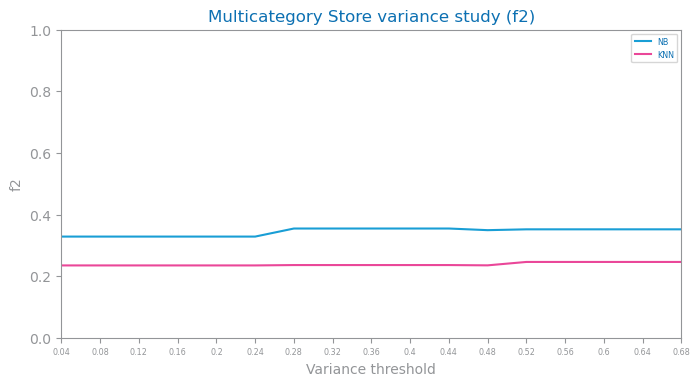

In [248]:
if evaluate==True:

    eval_metric = "f2"
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_variance_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        max_threshold=max_thresh,
        lag=lag_variance,
        metric=eval_metric,
        file_tag=file_tag,
        min_features_to_keep = 3,  # Minimum features safeguard
        exclude=mandatory_cols

    )
    show()

-> Best variance threshold for f2 = 0,3 - provide higher f2 for NB

### eval_metric_2 - recall


Testing threshold: 0.015
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.015: {'accuracy': [0.61421843752016, 0.6815689310367073], 'recall': [0.294151708164447, 0.24522292993630573], 'precision': [0.22290478279947346, 0.2666876574307305], 'auc': [0.5000683003344024, 0.5259483953242581], 'f1': [0.25361957064403395, 0.2555052790346908], 'f2': [0.2764776314357244, 0.249234934086629]}
Evaluation for recall: [0.294151708164447, 0.24522292993630573]
Testing threshold: 0.03
Dropping variables: []
Remaining features after drop: 18
Evaluation results at threshold 0.03: {'accuracy': [0.61421843752016, 0.6815689310367073], 'recall': [0.294151708164447, 0.24522292993630573], 'precision': [0.22290478279947346, 0.2666876574307305], 'auc': [0.5000683003344024, 0.5259483953242581], 'f1': [0.25361957064403395, 0.2555052790346908], 'f2': [0.2764776314357244, 0.249234934086629]}
Evaluation for recall: [0.294151708164447, 0.24522292993630573]
Testing threshold: 0

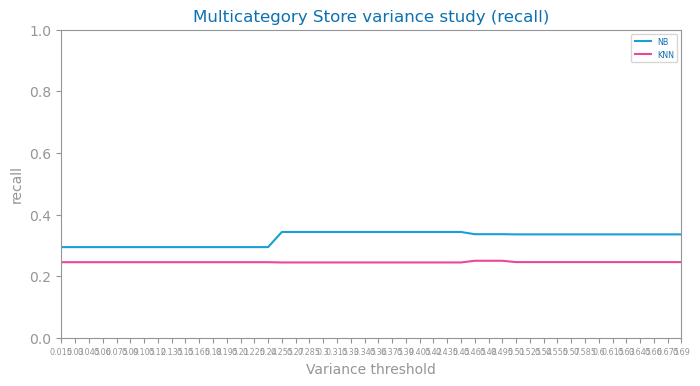

In [72]:
if evaluate==True:

    eval_metric = "recall"
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_variance_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        max_threshold=max_thresh,
        lag=lag_variance,
        metric=eval_metric,
        file_tag=file_tag,
        min_features_to_keep = 3,  # Minimum features safeguard
        exclude=mandatory_cols

    )
    show()

-> Best variance threshold for recall = 0,3 - provide higher recal for NB

#

## Feat 1 strategy Application

## Feat 1 strategy Application

In [73]:
from pandas import DataFrame, Index

def select_low_variance_variables(
    data: DataFrame, 
    max_threshold: float, 
    target: str = "is_purchase",
    min_features_to_keep: int = 10,  
    exclude: list[str] = ["day_of_year"]
) -> list:
    # Exclui as colunas que não devem ser consideradas
    data_filtered = data.drop(columns=exclude, errors='ignore')
    
    summary5: DataFrame = data_filtered.describe()

    # Calcula a variância
    variances = summary5.loc["std"] ** 2

    # Identifica as variáveis a serem removidas
    vars2drop: Index[str] = summary5.columns[variances < max_threshold]

    # Garante que a coluna alvo não seja removida
    if target in vars2drop:
        vars2drop = vars2drop.drop(target)

    # Garantia de que um número mínimo de recursos seja retido
    remaining_features = data_filtered.drop(vars2drop, axis=1).shape[1]
    if remaining_features < min_features_to_keep:
        print(f"Threshold too strict, keeping at least {min_features_to_keep} features.")
        vars2drop = summary5.columns[variances < max_threshold]
        remaining_features = data_filtered.drop(vars2drop, axis=1).shape[1]

        # Se ainda estiver muito poucos recursos, não remover nada
        if remaining_features < min_features_to_keep:
            print(f"Warning: Dropping too many features even with adjusted threshold.")
            vars2drop = Index([])  # Não remover nenhuma variável

    print(f"Variance threshold: {max_threshold}, Remaining features: {remaining_features}")
    print(f"Variables to drop: {list(vars2drop)}")

    return list(vars2drop.values)

def apply_remove_low_variance_variables(
    data: DataFrame,
    max_threshold=0.5,
    min_features_to_keep=10,
    target='is_purchase'
) -> DataFrame:
    
    # Chama a função para selecionar variáveis de baixa variância
    vars2drop: list[str] = select_low_variance_variables(
        data, 
        max_threshold=max_threshold, 
        min_features_to_keep=min_features_to_keep, 
        target=target
    )
    
    print("Columns to drop:", vars2drop)

    # Remove as colunas de baixa variância do DataFrame
    df_vars_drop = data.drop(columns=vars2drop, errors='ignore')
    
    print("Remaining columns:", df_vars_drop.columns)

    return df_vars_drop



In [249]:


def select_low_variance_variables(
    data: DataFrame, 
    max_threshold: float, 
    target: str = "is_purchase",
    min_features_to_keep: int = 10,  # Minimum number of features to retain
    exclude: list[str] = ["day_of_year"]  # Columns to exclude
) -> list:
    # Exclude the columns that should not be considered (like 'day_of_month')
    data_filtered = data.drop(columns=exclude, errors='ignore')
    
    summary5: DataFrame = data_filtered.describe()

    # Calculate variance (standard deviation squared)
    variances = summary5.loc["std"] ** 2

    # Drop features with variance below the max_threshold
    vars2drop: Index[str] = summary5.columns[variances < max_threshold]

    # Ensure that the target column is not dropped
    if target in vars2drop:
        vars2drop = vars2drop.drop(target)

    # Safeguard: Ensure a minimum number of features are retained
    remaining_features = data_filtered.drop(vars2drop, axis=1).shape[1]
    if remaining_features < min_features_to_keep:
        print(f"Threshold too strict, keeping at least {min_features_to_keep} features.")
        vars2drop = summary5.columns[variances < max_threshold]
        remaining_features = data_filtered.drop(vars2drop, axis=1).shape[1]

        # If still too few features, skip dropping
        if remaining_features < min_features_to_keep:
            print(f"Warning: Dropping too many features even with adjusted threshold.")
            vars2drop = Index([])  # Don't drop any variables

    print(f"Variance threshold: {max_threshold}, Remaining features: {remaining_features}")
    print(f"Variables to drop: {list(vars2drop)}")

    # Return the columns to drop, while preserving the excluded ones
    return list(vars2drop.values)


In [250]:

def apply_remove_low_variance_variables(df: DataFrame,max_threshold=0.3,min_features_to_keep=10,exclude=mandatory_cols,target='is_purchase') -> DataFrame:

    #from dslabs_functions import select_low_variance_variables
    # this script is available in data_functions originally from DSLabs site in Feature Selection chapter

    df_copy=df.copy()
    
    vars2drop: list[str] = select_low_variance_variables(df_copy, max_threshold=max_threshold, min_features_to_keep=min_features_to_keep,exclude=exclude, target=target)
    
    print("columns to drop:", vars2drop)

    df_vars_drop = df_copy.drop(columns=vars2drop, errors='ignore')
    
    print("Remaining columns:", df_vars_drop.columns)

    return df_vars_drop

In [251]:
from pandas import DataFrame, Index

def apply_strategy_1(df: DataFrame) -> DataFrame:

    # this script is available in data_functions originally from DSLabs site in Feature Selection chapter
    # threshold drop on recall nb is around 0.4 but precision increases
    df_copy=apply_remove_low_variance_variables(df,max_threshold=0.5, target=target, min_features_to_keep=3, exclude=mandatory_cols)
    
    # drop_additional = ['year', 'quarter']
    # df_copy = df_copy.drop(drop_additional, axis=1)  
    # print(f"Dropping additional columns from low variance study: {drop_additional}")
    
    return df_copy


df_1=apply_strategy_1(df)

df_1.describe()

Variance threshold: 0.5, Remaining features: 7
Variables to drop: ['is_weekend', 'time_of_day_cos', 'min_cos']
columns to drop: ['is_weekend', 'time_of_day_cos', 'min_cos']
Remaining columns: Index(['category_code_lvl_1', 'category_code_lvl_2', 'price', 'is_purchase',
       'activity_in_session', 'week_of_month', 'day', 'brand_value',
       'product_category', 'time_of_day_sin', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin'],
      dtype='object')


,category_code_lvl_1,category_code_lvl_2,price,is_purchase,activity_in_session,week_of_month,day,brand_value,product_category,time_of_day_sin,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin
count,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000
mean,0.910051,8.200088,308.113478,0.161891,3.850500,2.964152,16.953103,344.368450,4465.384974,-0.101503,-0.225357,-0.056782,0.148850,-0.306953,-0.002640
std,2.081828,11.976247,267.238655,0.368352,3.130559,0.911510,6.231992,242.649061,4392.211427,0.710637,0.681083,0.694528,0.731179,0.590777,0.709634
min,0.000000,0.000000,0.870000,0.000000,0.000000,1.000000,1.000000,2.900000,0.000000,-0.975000,-0.993000,-0.997000,-1.000000,-1.000000,-1.000000
25%,0.000000,3.000000,126.800000,0.000000,2.000000,2.000000,14.000000,173.500000,2093.000000,-0.975000,-0.775000,-0.632000,-0.707000,-0.866000,-0.743000
50%,0.000000,3.000000,205.430000,0.000000,3.000000,3.000000,16.000000,282.500000,2319.000000,0.000000,-0.081000,-0.041000,0.259000,-0.500000,0.000000
75%,1.000000,9.000000,398.980000,0.000000,5.000000,3.000000,20.000000,413.200000,5904.000000,0.624000,0.000000,0.693000,0.866000,0.259000,0.743000
max,12.000000,60.000000,1092.950000,1.000000,15.000000,5.000000,30.000000,862.600000,19212.000000,0.624000,0.999000,1.000000,1.000000,1.000000,1.000000


#### test

## Feat 1 train/test split 

Labels=[0, 1]


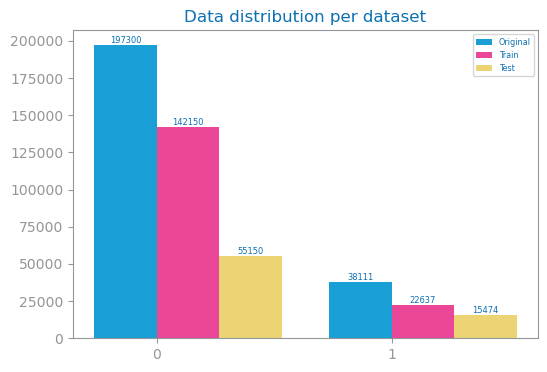

In [252]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    from numpy import array, ndarray


    y_1, X_1, labels, values = define_target_and_prepare_data(df_1, target)



    train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=df_1.columns), y_1, data_columns=df_1.columns, target_column=target)

    # Distribution check
    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Feat 1 evaluate

### optimize for target_metric_2 - precision

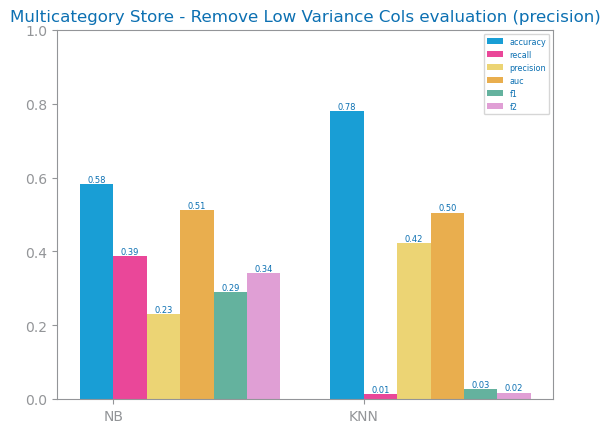

In [253]:
if evaluate==True:

    # evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
    # removed Multinomial from run_NB function because dataset has negative values

    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_purchase', metric=target_metric_2)
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag} - Remove Low Variance Cols evaluation ({target_metric_2})", percentage=True
    )
    savefig(f"images/{file_tag}_prep_feat_eng_approach_1_eval_{target_metric_2}.png")
    show()

### optimize for target metric - f2


In [256]:
from pandas import DataFrame, Index

def apply_strategy_1(df: DataFrame) -> DataFrame:

    # this script is available in data_functions originally from DSLabs site in Feature Selection chapter
    # threshold drop on recall nb is around 0.4 but precision increases
    df_copy=apply_remove_low_variance_variables(df,max_threshold=0.5, target=target, min_features_to_keep=3, exclude=mandatory_cols)
    
    # drop_additional = ['year', 'quarter']
    # df_copy = df_copy.drop(drop_additional, axis=1)  
    # print(f"Dropping additional columns from low variance study: {drop_additional}")
    
    return df_copy


df_1=apply_strategy_1(df)

df_1.describe()

Variance threshold: 0.5, Remaining features: 7
Variables to drop: ['is_weekend', 'time_of_day_cos', 'min_cos']
columns to drop: ['is_weekend', 'time_of_day_cos', 'min_cos']
Remaining columns: Index(['category_code_lvl_1', 'category_code_lvl_2', 'price', 'is_purchase',
       'activity_in_session', 'week_of_month', 'day', 'brand_value',
       'product_category', 'time_of_day_sin', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin'],
      dtype='object')


,category_code_lvl_1,category_code_lvl_2,price,is_purchase,activity_in_session,week_of_month,day,brand_value,product_category,time_of_day_sin,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin
count,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000,235411.000000
mean,0.910051,8.200088,308.113478,0.161891,3.850500,2.964152,16.953103,344.368450,4465.384974,-0.101503,-0.225357,-0.056782,0.148850,-0.306953,-0.002640
std,2.081828,11.976247,267.238655,0.368352,3.130559,0.911510,6.231992,242.649061,4392.211427,0.710637,0.681083,0.694528,0.731179,0.590777,0.709634
min,0.000000,0.000000,0.870000,0.000000,0.000000,1.000000,1.000000,2.900000,0.000000,-0.975000,-0.993000,-0.997000,-1.000000,-1.000000,-1.000000
25%,0.000000,3.000000,126.800000,0.000000,2.000000,2.000000,14.000000,173.500000,2093.000000,-0.975000,-0.775000,-0.632000,-0.707000,-0.866000,-0.743000
50%,0.000000,3.000000,205.430000,0.000000,3.000000,3.000000,16.000000,282.500000,2319.000000,0.000000,-0.081000,-0.041000,0.259000,-0.500000,0.000000
75%,1.000000,9.000000,398.980000,0.000000,5.000000,3.000000,20.000000,413.200000,5904.000000,0.624000,0.000000,0.693000,0.866000,0.259000,0.743000
max,12.000000,60.000000,1092.950000,1.000000,15.000000,5.000000,30.000000,862.600000,19212.000000,0.624000,0.999000,1.000000,1.000000,1.000000,1.000000


Labels=[0, 1]


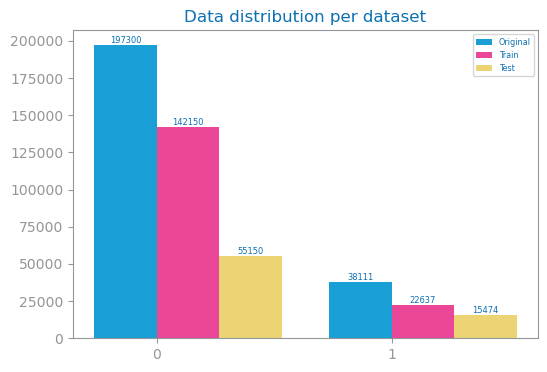

In [257]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    from numpy import array, ndarray


    y_1, X_1, labels, values = define_target_and_prepare_data(df_1, target)



    train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=df_1.columns), y_1, data_columns=df_1.columns, target_column=target)

    # Distribution check
    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

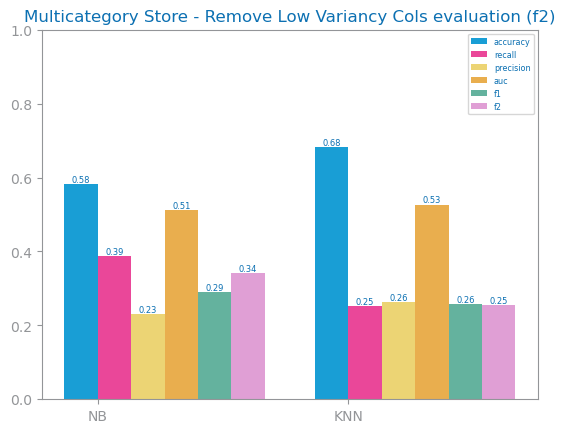

In [258]:
if evaluate==True:

    # evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
    # removed Multinomial from run_NB function because dataset has negative values

    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_purchase', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag} - Remove Low Variancy Cols evaluation ({target_metric})", percentage=True
    )
    savefig(f"images/{file_tag}_prep_feat_eng_approach_1_eval_{target_metric}.png")
    show()

# Feat 2 - Dropping Redundant Variables


In [259]:

def select_redundant_variables(
    data: DataFrame, 
    min_threshold: float = 0.90, 
    target: str = "class", 
    exclude: list[str] = ["day_of_year"]  # Columns to exclude from redundancy check
) -> list:
    # Exclude the columns that should not be considered (like 'day_of_month')
    data_filtered = data.drop(columns=[target] + exclude, errors='ignore')

    # Calculate the correlation matrix
    corr_matrix: DataFrame = abs(data_filtered.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []

    # Iterate over the variables and check correlations
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)  # Remove self-correlation
        if len(vars_corr) > 1:  # Check if more than one correlated variable
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)

    return vars2drop


def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
    exclude: list[str] = ["day_of_year"]  # Columns to exclude from redundancy check
) -> dict:
    # Generate the range of redundancy thresholds to test
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    # Ensure 'target' column is present and drop it for correlation calculation
    df: DataFrame = train.drop(target, axis=1, inplace=False)
    print(f"Columns in the train dataset: {df.columns.tolist()}")  # Debugging step

    # Calculate the correlation matrix
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    print(f"Variables considered for correlation: {variables.tolist()}")  # Debugging step

    results: dict[str, list] = {"NB": [], "KNN": []}
    
    for thresh in options:
        vars2drop: list = []
        
        # Loop through the variables to identify correlated features
        for v1 in variables:
            # Get features correlated with the current variable
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            
            # Check if the current variable is in the correlation list before trying to drop it
            if v1 in vars_corr:
                vars_corr.drop(v1, inplace=True)
            
            # If other variables are highly correlated with v1, consider them for removal
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        print(f"Variables to drop at threshold {thresh}: {vars2drop}")  # Debugging step
        
        # Drop the selected redundant variables from train and test datasets
        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)

        # Evaluate the approach using the current feature set
        eval: dict | None = evaluate_approach(train_copy, test_copy, target=target, metric=metric)

        # Check if evaluation returned results
        if eval:
            print(f"Evaluation results at threshold {thresh}: {eval}")
            if metric in eval:
                print(f"Evaluation for {metric}: {eval[metric]}")
                results["NB"].append(eval[metric][0])
                results["KNN"].append(eval[metric][1])
            else:
                print(f"Metric '{metric}' not found in evaluation results at threshold {thresh}.")
                results["NB"].append(None)
                results["KNN"].append(None)
        else:
            print(f"Evaluation failed or returned empty at threshold {thresh}.")
            results["NB"].append(None)
            results["KNN"].append(None)

    # Optional: Save or plot the results after evaluation
    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
    return results


In [260]:
min_thresh=0.6
lag_redundacy=0.025

mandatory_cols=[ 
'day_of_week_sin',
'activity_in_session',
'week_of_month',
'day_of_week_cos',
'hour_sin',
'hour_cos',
'day',
'is_purchase'
]


In [261]:
# At the start of the for loop in study_redundancy_for_feature_selection
print(f"Initial number of features: {df.shape[1]}")
print(f"Redundancy threshold: {min_thresh}")

Initial number of features: 18
Redundancy threshold: 0.6


### precision study

Columns in the train dataset: ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'is_weekend', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables considered for correlation: ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'is_weekend', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables to drop at threshold 0.6: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Evaluation results at threshold 0.6: {'accuracy': [0.6015293118096856, 0.7725856697819314], 'recall': [0.34683381549341047, 0.02700096432015429], 'precision': [0.23080213903743316, 0.31226765799256506], 'auc': [0.5101553078193467, 0.5051013175364506], 'f1': [0.2771641407654765, 0.

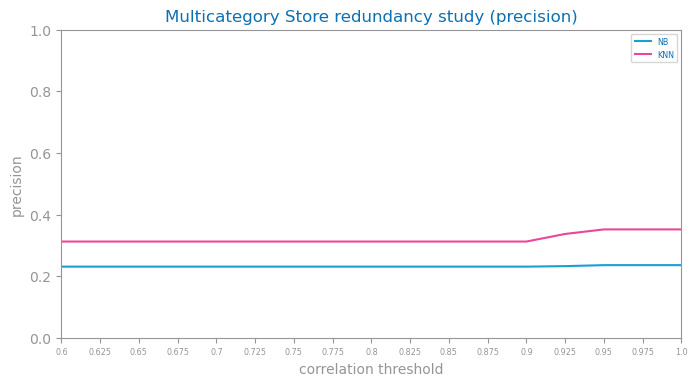

In [262]:
if evaluate==True:

    # modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)


    eval_metric = "precision"
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_redundancy_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        min_threshold = min_thresh,
        lag = lag_redundacy,
        metric=eval_metric,
        file_tag=file_tag,
        exclude=mandatory_cols

    )
    show()

Columns in the train dataset: ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'is_weekend', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables considered for correlation: ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'is_weekend', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables to drop at threshold 0.5: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1', 'time_of_day_cos', 'hour_sin']
Evaluation results at threshold 0.5: {'accuracy': [0.59899361331527, 0.7813044319721308], 'recall': [0.3181818181818182, 0.004132231404958678], 'precision': [0.21629213483146068, 0.4666666666666667], 'auc': [0.4978591745907852, 0.5014056682493299], '

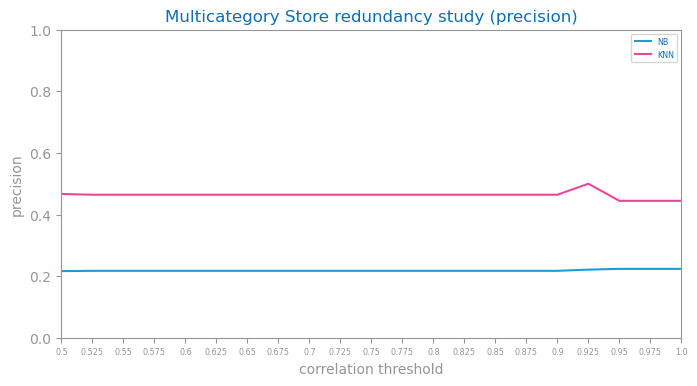

In [172]:
if evaluate==True:

    # modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)


    eval_metric = target_metric_2
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_redundancy_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        min_threshold = min_thresh,
        lag = lag_redundacy,
        metric=eval_metric,
        file_tag=file_tag
        )
    show()

### f2 study

Columns in the train dataset: ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'is_weekend', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables considered for correlation: ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'is_weekend', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos']
Variables to drop at threshold 0.3: ['category_code_lvl_2', 'brand_value', 'product_category', 'category_code_lvl_1', 'is_weekend', 'day', 'day_of_week_sin', 'week_of_month', 'day_of_week_cos', 'price', 'time_of_day_cos', 'hour_sin']
Evaluation failed or returned empty at threshold 0.3.
Variables to drop at threshold 0.325: ['category_code_lvl_2', 'product_category', 'category_code

TypeError: '<' not supported between instances of 'NoneType' and 'int'

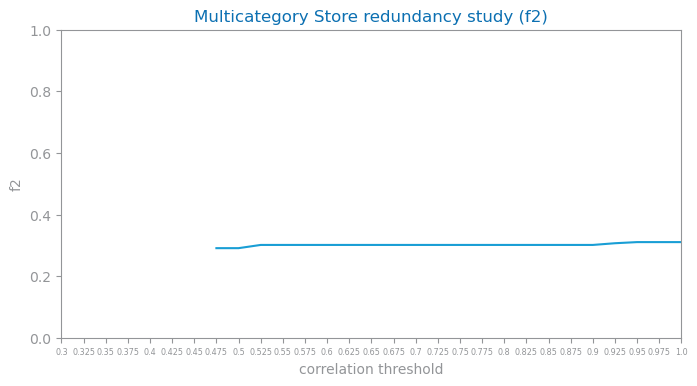

In [176]:
if evaluate==True:

    # modified study_variance_for_feature_selection() in dslabs functions to keep minimum variables and print metrics (due to error)


    eval_metric = target_metric
    figure(figsize=(2 * HEIGHT, HEIGHT))
    study_redundancy_for_feature_selection(
        train_sample,
        test_sample,
        target=target,
        min_threshold = min_thresh,
        lag = lag_redundacy,
        metric=eval_metric,
        file_tag=file_tag,
        exclude=mandatory_cols
    )
    show()

## Feat 2 - Study redundant variables and threshold

## Feat 2 strategy aplication

In [89]:

def select_redundant_variables(
    data: DataFrame, 
    min_threshold: float = 1, 
    target: str = "is_purchase", 
    exclude: list[str] = ["day_of_year"]  # Columns to exclude from redundancy check
) -> list:
    # Exclude the columns that should not be considered (like 'day_of_month')
    data_filtered = data.drop(columns=[target] + exclude, errors='ignore')

    # Calculate the correlation matrix
    corr_matrix: DataFrame = abs(data_filtered.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []

    # Iterate over the variables and check correlations
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)  # Remove self-correlation
        if len(vars_corr) > 1:  # Check if more than one correlated variable
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)

    return vars2drop

In [263]:
from pandas import DataFrame, Series, Index

def select_redundant_variables(
    data: DataFrame, 
    min_threshold: float = 1, 
    target: str = "is_purchase", 
    exclude: list[str] = ["day_of_year"]
) -> list:
    print("Iniciando a função select_redundant_variables...")
    # Criar uma cópia do DataFrame e remover as colunas que não devem ser consideradas
    data_filtered = data.drop(columns=[target] + exclude, errors='ignore')

    # Calcular a matriz de correlação
    corr_matrix: DataFrame = abs(data_filtered.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []

    # Iterar sobre as variáveis e verificar correlações
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)  # Remover auto-correlação
        if len(vars_corr) > 1:  # Verificar se mais de uma variável correlacionada
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)

    print("Saindo da função select_redundant_variables com vars2drop:", vars2drop)
    return vars2drop

def apply_remove_redundant_variables(df: DataFrame, min_threshold=0.8, exclude=['day_of_year'], target='is_purchase') -> DataFrame:
    df_copy = df.copy()

    # Verifique se as colunas alvo estão corretas
    print(f"Excluindo as seguintes colunas: {exclude + [target]}")  # Debugging step

    # Chame a função para obter as colunas a serem removidas
    vars2drop = select_redundant_variables(df_copy, min_threshold=min_threshold, exclude=exclude, target=target)
    
    # Imprimindo informações detalhadas
    print(f"Variance threshold: {min_threshold}, Variables to drop: {vars2drop}")
    
    # Verifique se as colunas a serem removidas estão realmente presentes
    missing_vars = [var for var in vars2drop if var not in df_copy.columns]
    if missing_vars:
        print(f"As seguintes colunas não estão presentes no DataFrame: {missing_vars}")

    # Remover as colunas do DataFrame, mas manter a coluna target
    df_vars_drop = df_copy.drop(columns=vars2drop, errors='ignore')
    print("Columns to drop:", vars2drop)
    print("Remaining columns:", df_vars_drop.columns)

    return df_vars_drop


In [139]:

def apply_strategy_2(df: DataFrame, target='is_purchase'):
    print(f"Applying strategy 2 with target '{target}'...")
    df_copy = apply_remove_redundant_variables(df, min_threshold=0.5, exclude=['day_of_year'], target=target)
    print("Final DataFrame after applying strategy 2:")
    print(df_copy)
    return df_copy

# Chamada da função com o seu DataFrame df
result_df = apply_strategy_2(df, target='is_purchase')
print(result_df)

Applying strategy 2 with target 'is_purchase'...
Excluindo as seguintes colunas: ['day_of_year', 'is_purchase']
Iniciando a função select_redundant_variables...
Saindo da função select_redundant_variables com vars2drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1', 'time_of_day_cos', 'hour_sin']
Variance threshold: 0.5, Variables to drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1', 'time_of_day_cos', 'hour_sin']
Columns to drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1', 'time_of_day_cos', 'hour_sin']
Remaining columns: Index(['price', 'is_purchase', 'activity_in_session', 'week_of_month',
       'is_weekend', 'day', 'brand_value', 'time_of_day_sin',
       'day_of_week_sin', 'day_of_week_cos', 'hour_cos', 'min_sin', 'min_cos'],
      dtype='object')
Final DataFrame after applying strategy 2:
          price  is_purchase  activity_in_session  week_of_month  is_weekend  \
0        949.47            0                  3.

In [264]:
from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler

def apply_strategy_2(df):


    df_copy = apply_remove_redundant_variables(df, min_threshold=0.5, exclude=mandatory_cols, target=target)


    return df_copy


df_2=df.copy()

df_2=apply_strategy_2(df_2)

Excluindo as seguintes colunas: ['day_of_week_sin', 'activity_in_session', 'week_of_month', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'day', 'is_purchase', 'is_purchase']
Iniciando a função select_redundant_variables...
Saindo da função select_redundant_variables com vars2drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Variance threshold: 0.5, Variables to drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Columns to drop: ['category_code_lvl_2', 'product_category', 'category_code_lvl_1']
Remaining columns: Index(['price', 'is_purchase', 'activity_in_session', 'week_of_month',
       'is_weekend', 'day', 'brand_value', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos', 'min_sin', 'min_cos'],
      dtype='object')


In [112]:
df_2.head()

,price,is_purchase,activity_in_session,week_of_month,is_weekend,day,brand_value,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos
0,949.47,0,3.0,1,0,1,779.2,0.624,-0.781,-0.775,-0.632,0.966,0.259,-0.105,0.995
1408,170.14,0,25.0,1,0,1,282.5,-0.975,0.221,-0.775,-0.632,-0.966,-0.259,-0.208,-0.978
1407,44.53,1,0.0,1,0,1,51.1,-0.975,0.221,-0.775,-0.632,0.000,-1.000,-0.669,0.743
1406,211.32,0,1.0,1,0,1,173.5,-0.975,0.221,-0.775,-0.632,-0.866,-0.500,0.105,-0.995
1405,453.16,1,3.0,1,0,1,779.2,-0.624,-0.781,-0.775,-0.632,-0.707,0.707,0.407,-0.914


## Feat 2 train/test split 

Labels=[0, 1]


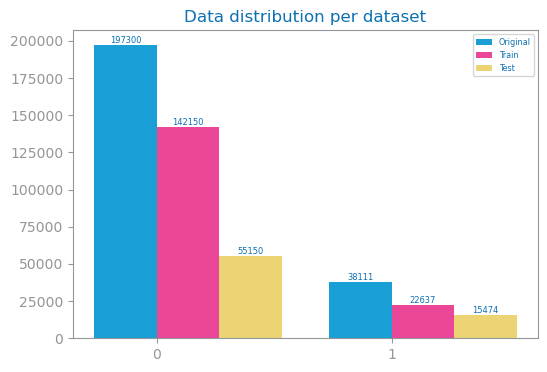

In [265]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    from numpy import array, ndarray


    y_2, X_2, labels, values = define_target_and_prepare_data(df_2, target)



    train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=df_2.columns), y_2, data_columns=df_2.columns, target_column=target)

    # Distribution check
    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Feat 2 evaluate

### eval target_metric_2 - precision

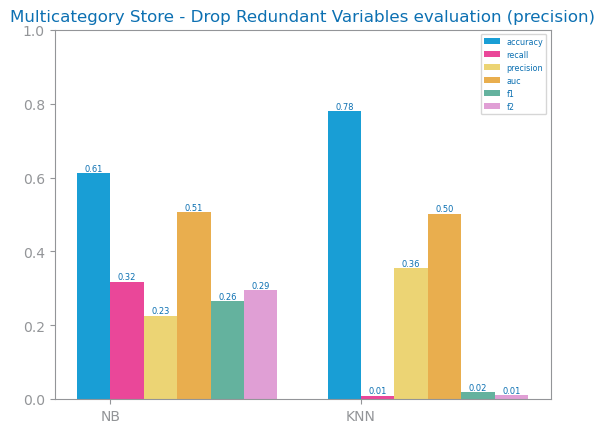

In [266]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_purchase', metric=target_metric_2)
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag} - Drop Redundant Variables evaluation ({target_metric_2})", percentage=True
    )
    savefig(f"images/{file_tag}_prep_feat_eng_approach_2_evaluation_{target_metric_2}.png")
    show()

### eval target_metric - f2

In [273]:
from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler

def apply_strategy_2(df):


    df_copy = apply_remove_redundant_variables(df, min_threshold=0.2, exclude=mandatory_cols, target=target)


    return df_copy


df_2=df.copy()

df_2=apply_strategy_2(df_2)

Excluindo as seguintes colunas: ['day_of_week_sin', 'activity_in_session', 'week_of_month', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'day', 'is_purchase', 'is_purchase']
Iniciando a função select_redundant_variables...
Saindo da função select_redundant_variables com vars2drop: ['category_code_lvl_2', 'price', 'brand_value', 'product_category', 'category_code_lvl_1']
Variance threshold: 0.2, Variables to drop: ['category_code_lvl_2', 'price', 'brand_value', 'product_category', 'category_code_lvl_1']
Columns to drop: ['category_code_lvl_2', 'price', 'brand_value', 'product_category', 'category_code_lvl_1']
Remaining columns: Index(['is_purchase', 'activity_in_session', 'week_of_month', 'is_weekend',
       'day', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos'],
      dtype='object')


Labels=[0, 1]


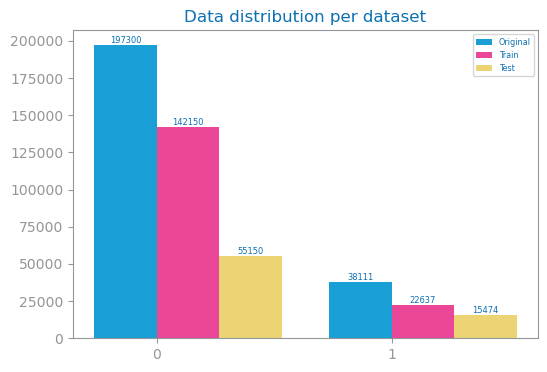

In [274]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    from numpy import array, ndarray


    y_2, X_2, labels, values = define_target_and_prepare_data(df_2, target)



    train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=df_2.columns), y_2, data_columns=df_2.columns, target_column=target)

    # Distribution check
    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

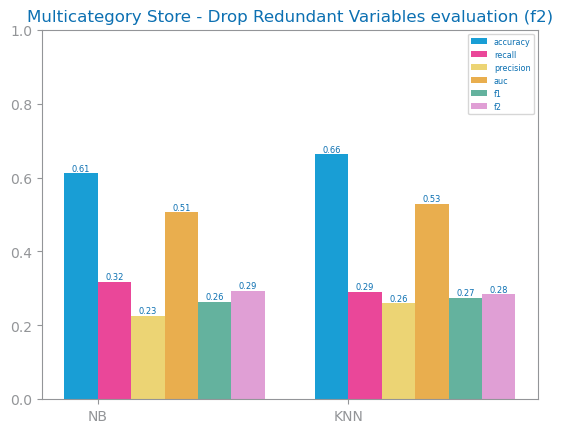

In [275]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_purchase', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag} - Drop Redundant Variables evaluation ({target_metric})", percentage=True
    )
    savefig(f"images/{file_tag}_prep_feat_eng_approach_2_evaluation_{target_metric}.png")
    show()

In [78]:
train_2.head()

,price,activity_in_session,week_of_month,is_weekend,day,brand_value,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos
0,261.55,3.0,2.0,0.0,8.0,455.0,0.624,-0.781,-0.775,-0.632,0.259,-0.966,0.669,-0.743
1,915.08,4.0,2.0,0.0,8.0,779.2,-0.975,0.221,-0.775,-0.632,-0.966,-0.259,0.866,0.500
2,2.63,2.0,2.0,0.0,8.0,16.9,0.624,-0.781,-0.775,-0.632,0.966,-0.259,0.105,0.995
3,980.21,4.0,2.0,0.0,8.0,779.2,0.624,-0.781,-0.775,-0.632,0.966,-0.259,0.208,0.978
4,194.89,4.0,2.0,0.0,8.0,282.5,-0.975,0.221,-0.775,-0.632,-0.707,-0.707,0.914,0.407


# Approach uplift comparison

## uplift df

In [116]:
if evaluate == True:
    
    algorithms = ['Naive Bayes', 'KNN']

    # Create DataFrames for eval_1 and eval_2
    df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
    df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

    # Calculate uplift
    df_uplift = df_eval_2 - df_eval_1



    # Combine everything into one DataFrame (without misalignment issues)
    comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
    comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



    # Display the DataFrame
    display(comparison_df)

Approach 1                                                    \
              accuracy    recall precision       auc        f1        f2   
Naive Bayes   0.592392  0.349739  0.225262  0.505278  0.274027  0.314933   
KNN           0.680017  0.226843  0.249709  0.517324  0.237728  0.231075   

            Approach 2                                                    \
              accuracy    recall precision       auc        f1        f2   
Naive Bayes   0.597708  0.327800  0.220808  0.500809  0.263871  0.298840   
KNN           0.667862  0.234176  0.239357  0.512165  0.236738  0.235194   

               Uplift                                                    
             accuracy    recall precision       auc        f1        f2  
Naive Bayes  0.005316 -0.021939 -0.004453 -0.004469 -0.010156 -0.016094  
KNN         -0.012155  0.007333 -0.010352 -0.005159 -0.000990  0.004119

# Analysis

Comparing approaches:
- No improvement (actuall loss)

Comparing with previous dataset:
- For now lets go with feature enginerring dataset

Decision:
- In balancing, feature engineering values dataset

# save to csv

In [276]:
if test_data==False:
    
    
    data_save=df.copy()

    data_save=apply_strategy_2(data_save)
        
    data_save.to_csv(f"dataset/df_ecom_2_5_feat_eng_input.csv", index=False)


    print(data_save.columns)



Excluindo as seguintes colunas: ['day_of_week_sin', 'activity_in_session', 'week_of_month', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'day', 'is_purchase', 'is_purchase']
Iniciando a função select_redundant_variables...
Saindo da função select_redundant_variables com vars2drop: ['category_code_lvl_2', 'price', 'brand_value', 'product_category', 'category_code_lvl_1']
Variance threshold: 0.2, Variables to drop: ['category_code_lvl_2', 'price', 'brand_value', 'product_category', 'category_code_lvl_1']
Columns to drop: ['category_code_lvl_2', 'price', 'brand_value', 'product_category', 'category_code_lvl_1']
Remaining columns: Index(['is_purchase', 'activity_in_session', 'week_of_month', 'is_weekend',
       'day', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos'],
      dtype='object')
Index(['is_purchase', 'activity_in_session', 'week_of_month', 'is_weekend',
       'day', 'time_of_day_sin', 'time_of_day_cos

## train test csv

In [277]:
if test_data==False:
    

    data_save_copy=data_save.copy()

    
    y, X, labels, class_counts = define_target_and_prepare_data(data_save_copy, target=target)

    train, test = split_data_save_csv(pd.DataFrame(X, columns=data_save_copy.columns), y, data_columns=data_save_copy.columns, target_column=target)  
    
    train.to_csv(f"dataset/df_ecom_2_5_feat_eng_input_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"dataset/df_ecom_2_5_feat_eng_input_test.csv", index=False)
    print(test.columns)

Labels=[0, 1]
Index(['activity_in_session', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'is_purchase'],
      dtype='object')
Index(['activity_in_session', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'is_purchase'],
      dtype='object')
